### First, we will import necessary libraries and set display settings.

In [96]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import eli5
import datetime as dt
from scipy.sparse import hstack

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display_html

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, TimeSeriesSplit
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler

sns.set()

%matplotlib inline

%config InlineBackend.figure_format = 'svg'

plt.rcParams['figure.figsize'] = (8, 5)
plt.rcParams['image.cmap'] = 'plasma'

### Here we will create a function to ease a way to write our submission in file

In [97]:
def write_to_sub_file(y_pred, file_name):
    
    prediction = pd.DataFrame(y_pred, 
                              index=np.arange(1, y_pred.shape[0] + 1),
                              columns=['target'])
    
    prediction.to_csv(file_name, index_label='session_id')

### Let's read our datasets and see some information about them.

In [98]:
df_train = pd.read_csv('/home/kap/DS/DataSets/Alice/train_sessions.csv')
df_test = pd.read_csv('/home/kap/DS/DataSets/Alice/test_sessions.csv')

df_train = df_train.sort_values(by='time1')

In [99]:
df_train.head(2)

,session_id,site1,time1,site2,time2,site3,time3,site4,time4,site5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
21668,21669,56,2013-01-12 08:05:57,55.0,2013-01-12 08:05:57,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
54842,54843,56,2013-01-12 08:37:23,55.0,2013-01-12 08:37:23,56.0,2013-01-12 09:07:07,55.0,2013-01-12 09:07:09,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [196]:
df_train.info()
print('-' * 40)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 253561 entries, 21668 to 204761
Data columns (total 22 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   session_id  253561 non-null  int64  
 1   site1       253561 non-null  int64  
 2   time1       253561 non-null  object 
 3   site2       250098 non-null  float64
 4   time2       250098 non-null  object 
 5   site3       246919 non-null  float64
 6   time3       246919 non-null  object 
 7   site4       244321 non-null  float64
 8   time4       244321 non-null  object 
 9   site5       241829 non-null  float64
 10  time5       241829 non-null  object 
 11  site6       239495 non-null  float64
 12  time6       239495 non-null  object 
 13  site7       237297 non-null  float64
 14  time7       237297 non-null  object 
 15  site8       235224 non-null  float64
 16  time8       235224 non-null  object 
 17  site9       233084 non-null  float64
 18  time9       233084 non-null  object 
 19

### As usual, we have some number of empty values. Let's read 'site_dic.pkl' (ids of sites) and check if datasets contain sites with index '0'. If not, we can fill empty cells with zeros.

In [141]:
site_dict = pd.read_pickle('/home/kap/Downloads/site_dic.pkl')
df_site_name = pd.DataFrame.from_dict(site_dict, orient='index', columns=['A'])
df_site_name.sort_values(by='A', ascending=True).head(3)

,A
fpdownload2.macromedia.com,1
hotmail.fr,2
login.live.com,3


### To create the first simple prediction, we will get rid of columns 'time' and 'session_id' and try to predict session-owner using only site IDs.

In [102]:
time_col = [col for col in df_train.columns if 'time' in col or 'sess' in col]

In [103]:
X_train = df_train.drop(columns=time_col, axis=1).fillna(0).astype('int').iloc[:, :-1]
y_train = df_train.target.astype('int')
X_test = df_test.drop(columns=time_col, axis=1).fillna(0).astype('int')

X_train.shape, X_test.shape, y_train.shape

((253561, 10), (82797, 10), (253561,))

In [197]:
df_train.info()
print('-' * 40)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 253561 entries, 21668 to 204761
Data columns (total 22 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   session_id  253561 non-null  int64  
 1   site1       253561 non-null  int64  
 2   time1       253561 non-null  object 
 3   site2       250098 non-null  float64
 4   time2       250098 non-null  object 
 5   site3       246919 non-null  float64
 6   time3       246919 non-null  object 
 7   site4       244321 non-null  float64
 8   time4       244321 non-null  object 
 9   site5       241829 non-null  float64
 10  time5       241829 non-null  object 
 11  site6       239495 non-null  float64
 12  time6       239495 non-null  object 
 13  site7       237297 non-null  float64
 14  time7       237297 non-null  object 
 15  site8       235224 non-null  float64
 16  time8       235224 non-null  object 
 17  site9       233084 non-null  float64
 18  time9       233084 non-null  object 
 19

### Now we will look at distribution ours target. It is important to know to understand how real target can correlate  with prediction. Using this information, we can pick more valuable metrics. 

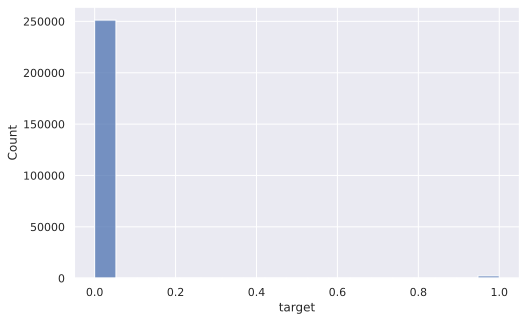

In [105]:
sns.histplot(data=df_train.target);

In [106]:
df_train.target.value_counts(normalize=True)

0    0.990941
1    0.009059
Name: target, dtype: float64

### Next, we will perform cross-validation with Decision Tree and Random Forest.

In [107]:
tree = DecisionTreeClassifier(random_state=17)

In [108]:
rf = RandomForestClassifier(random_state=17)

In [64]:
%%time

#Decision Tree

cv_scores = cross_val_score(tree, X_train, y_train, cv=5, scoring='roc_auc', n_jobs=-1)
cv_scores, cv_scores.mean()

CPU times: user 48.7 ms, sys: 16.3 ms, total: 65 ms
Wall time: 5.08 s


(array([0.6020137 , 0.59756092, 0.60269682, 0.59506715, 0.59839232]),
 0.5991461831163952)

In [65]:
%%time

#Random Forest

cv_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='roc_auc', n_jobs=-1)
cv_scores, cv_scores.mean()

CPU times: user 72.8 ms, sys: 9.22 ms, total: 82.1 ms
Wall time: 2min 12s


(array([0.89068911, 0.86946929, 0.89221277, 0.88656748, 0.88155944]),
 0.8840996168171896)

### Using Random Forest we got roc_auc = 0.88 on our training set. Let's add start session time and map them to 0 - morning, 1 - day, 2 - evening and 3 - night.

In [71]:
X_train['hour'] = df_train.time1.astype('datetime64[ns]').dt.hour
X_test['hour'] = df_test.time1.astype('datetime64[ns]').dt.hour
X_train.shape, X_test.shape

((253561, 11), (82797, 11))

In [72]:
h = np.arange(7, 24)

#day_time = ['morning'] * 4 + ['day'] * 4 + ['evening'] * 5 + ['night'] * 4

day_time = [0] * 4 + [1] * 4 + [2] * 5 + [3] * 4
day_time_dict = dict(zip(h, day_time))

X_train['hour'] = X_train['hour'].map(day_time_dict)
X_test['hour'] = X_test['hour'].map(day_time_dict)

X_train.shape, X_test.shape, y_train.shape

((253561, 11), (82797, 11), (253561,))

In [74]:
%%time

cv_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='roc_auc', n_jobs=-1)
cv_scores, cv_scores.mean()

CPU times: user 58.3 ms, sys: 17 ms, total: 75.4 ms
Wall time: 1min 36s


(array([0.92430205, 0.92127924, 0.91819546, 0.92376791, 0.9280678 ]),
 0.9231224927270139)

### Here we got roc_auc = 0.92. Let's submit this result.

In [75]:
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=17)

In [76]:
y_pred = rf.predict_proba(X_test)[:,1]

In [77]:
write_to_sub_file(y_pred, 'sub4.csv') # Submission score - 0.77334

### Finally, we will choose the best parameters for our model.

In [290]:
params = {'max_depth': np.arange(8, 20, 4), 'min_samples_split': np.arange(2, 14, 4)}

In [291]:
clf = GridSearchCV(rf, param_grid=params, scoring='roc_auc', cv=5)

In [292]:
%%time

clf.fit(X_train, y_train)

CPU times: user 25min 49s, sys: 402 ms, total: 25min 50s
Wall time: 25min 52s


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(max_depth=16, random_state=17),
             param_grid={'max_depth': array([ 8, 12, 16]),
                         'min_samples_split': array([ 2,  6, 10])},
             scoring='roc_auc')

In [297]:
clf.best_estimator_

RandomForestClassifier(max_depth=16, min_samples_split=10, random_state=17)

In [305]:
y_pred = clf.predict_proba(X_test)[:,1]

In [306]:
write_to_sub_file(y_pred, 'sub6.csv') # Submission score - 0.81486

### Ok. Now we will use a slightly more advanced technique that named "Bag of words".
###  When we work with time series, we should use a more advanced method to cross-validation (Time Series Split). So, first we will sort our dataset by ascending order, and then we will split it into 8 parts.
#### Here is an image to explain:

### 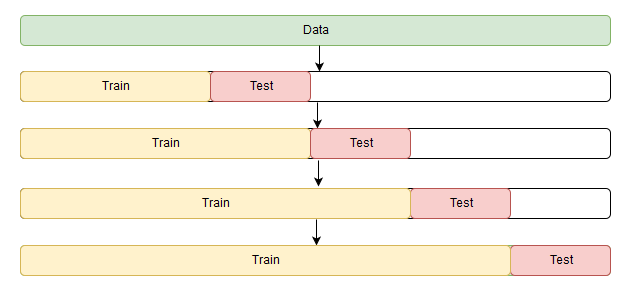

In [109]:
X_train = df_train.drop(columns=time_col, axis=1).fillna(0).astype('int').iloc[:, :-1]

time_split = TimeSeriesSplit(n_splits=8)

[(e[0].shape, e[1].shape) for e in time_split.split(X_train)]

[((28177,), (28173,)),
 ((56350,), (28173,)),
 ((84523,), (28173,)),
 ((112696,), (28173,)),
 ((140869,), (28173,)),
 ((169042,), (28173,)),
 ((197215,), (28173,)),
 ((225388,), (28173,))]

### Transform our data to feed it CountVecrorizer.

In [110]:
X_train.to_csv('X_train_txt.txt', sep=' ', header=None, index=None)
X_test.to_csv('X_test_txt.txt', sep=' ', header=None, index=None)

In [111]:
!head X_train_txt.txt

56 55 0 0 0 0 0 0 0 0
56 55 56 55 0 0 0 0 0 0
946 946 951 946 946 945 948 784 949 946
945 948 949 948 945 946 947 945 946 946
947 950 948 947 950 952 946 951 946 947
952 947 953 946 947 946 953 955 946 947
953 947 946 953 955 947 953 946 953 1033
946 947 954 953 946 954 946 956 957 956
946 956 946 946 955 954 946 946 946 948
948 946 948 784 49 53 812 982 52 52


In [121]:
vect = CountVectorizer(ngram_range=(1, 3), max_features=80000)

In [122]:
%%time
X_train_vectorized = vect.fit_transform(open('X_train_txt.txt'))
X_test_vectorized = vect.transform(open('X_test_txt.txt'))

X_train_vectorized.shape, X_test_vectorized.shape

CPU times: user 9.02 s, sys: 150 ms, total: 9.17 s
Wall time: 9.17 s


((253561, 80000), (82797, 80000))

### Perform time series cross-validation with logistic regression.

In [123]:
logreg_vect = LogisticRegression(C=1, random_state=17, solver='liblinear')

In [124]:
%%time

cv_score = cross_val_score(logreg_vect, X_train_vectorized, y_train, scoring='roc_auc', cv=time_split)
cv_score.mean()

CPU times: user 2min 47s, sys: 1min 37s, total: 4min 25s
Wall time: 1min 19s


0.8534236232323502

In [125]:
logreg_vect.fit(X_train_vectorized, y_train)

LogisticRegression(C=1, random_state=17, solver='liblinear')

In [126]:
y_pred = logreg_vect.predict_proba(X_test_vectorized)[:, 1]

In [127]:
write_to_sub_file(y_pred, 'sub8_logreg_vectorized.csv') # Submission score - 0.91326

### Using eli5 we can see the weight of features.

In [138]:
eli5.show_weights(estimator=logreg_vect, feature_names=vect.get_feature_names(), top=10)

### Next we will add start session time. 

In [162]:
hour_train = df_train['time1'].astype('datetime64[ns]').apply(lambda ts: ts.hour)
hour_test = df_test['time1'].astype('datetime64[ns]').apply(lambda ts: ts.hour)

In [163]:
morning_train = ((hour_train >= 7) & (hour_train <= 11)).astype('int')
day_train = ((hour_train >= 12) & (hour_train <= 18)).astype('int')
evening_train = ((hour_train >= 19) & (hour_train <= 23)).astype('int')
night_train = ((hour_train >= 0) & (hour_train <= 6)).astype('int')

morning_test = ((hour_test >= 7) & (hour_test <= 11)).astype('int')
day_test = ((hour_test >= 12) & (hour_test <= 18)).astype('int')
evening_test = ((hour_test >= 19) & (hour_test <= 23)).astype('int')
night_test = ((hour_test >= 0) & (hour_test <= 6)).astype('int')

In [164]:
%%time

X_train_new = hstack([X_train_vectorized, morning_train.values.reshape(-1, 1),
                     day_train.values.reshape(-1, 1), evening_train.values.reshape(-1, 1),
                     night_train.values.reshape(-1, 1)])

X_test_new = hstack([X_test_vectorized, morning_test.values.reshape(-1, 1),
                     day_test.values.reshape(-1, 1), evening_test.values.reshape(-1, 1),
                     night_test.values.reshape(-1, 1)]) # 0.9770486694430115

CPU times: user 92.4 ms, sys: 8.28 ms, total: 101 ms
Wall time: 100 ms


In [165]:
%%time

cv_score = cross_val_score(logreg_vect, X_train_new, y_train, scoring='roc_auc', cv=time_split)
cv_score.mean()

CPU times: user 2min 14s, sys: 1min 26s, total: 3min 41s
Wall time: 1min 4s


0.9081766206472384

### Roc_auc metric increased significantly (0.85 > 0.91). Let's do another submission.

In [166]:
logreg_vect.fit(X_train_new, y_train)

LogisticRegression(C=1, random_state=17, solver='liblinear')

In [167]:
y_pred = logreg_vect.predict_proba(X_test_new)[:, 1]

In [168]:
write_to_sub_file(y_pred, 'sub10_logreg_vectorized.csv') # Submission score - 0.93897

### Next, we will see what favorite days for browsing the internet for Alice and other users.

In [181]:
day_of_week_train = (df_train.time1.astype('datetime64[ns]').dt.day_of_week).astype('int')
day_of_week_test = (df_test.time1.astype('datetime64[ns]').dt.day_of_week).astype('int')

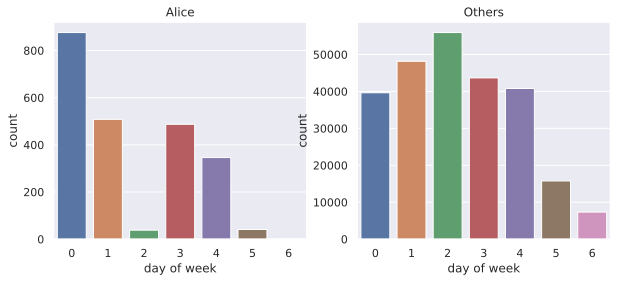

In [182]:
plt.subplots(1, 3, figsize = (10, 4))

plt.subplot(1, 2, 1)
sns.countplot(work_day_train[y_train == 1])
plt.title("Alice")
plt.xlabel('day of week')

plt.subplot(1, 2, 2)
sns.countplot(day_of_week_train[y_train == 0])
plt.title('Others')
plt.xlabel('day of week');

### Alice browsing more on Monday, then her activity decreases, while other users prefer Wednesday. We can use this distinction to refine the model. Add some new features: day of week, session duration and year-month values.

In [183]:
session_duration_train = ((df_train.time10.astype('datetime64[ns]') - df_train.time1.astype('datetime64[ns]')) 
     / np.timedelta64(1, 'h')).fillna(0)

session_duration_test = ((df_test.time10.astype('datetime64[ns]') - df_test.time1.astype('datetime64[ns]')) 
     / np.timedelta64(1, 'h')).fillna(0)

In [198]:
time_train = df_train.time1.astype('datetime64[ns]')
time_test = df_test.time1.astype('datetime64[ns]')
time_train_min = time_train.dt.year.min()
time_test_min = time_test.dt.year.min()

# To avoid a big variety of data and do not break the logistic regression model, we need to 'normalize' data.
# Let's implement year_month feature as number of months since first session and divide it by 100.

year_month_train = time_train.apply(lambda ts: ((ts.year - time_train_min) * 12 + ts.month) / 1e2 )
year_month_test = time_test.apply(lambda ts: ((ts.year - time_train_min) * 12 + ts.month) / 1e2 )

In [186]:
X_train_newest = hstack([X_train_new, day_of_week_train.values.reshape(-1, 1),
                                      session_duration_train.values.reshape(-1, 1),
                                      year_month_train.values.reshape(-1, 1)])


X_test_newest = hstack([X_test_new, day_of_week_test.values.reshape(-1, 1),
                                    session_duration_test.values.reshape(-1, 1),
                                    year_month_test.values.reshape(-1, 1)])

In [188]:
%%time

cv_score = cross_val_score(logreg_vect, X_train_newest, y_train, scoring='roc_auc', cv=time_split)
cv_score.mean()

CPU times: user 3min 27s, sys: 2min 12s, total: 5min 39s
Wall time: 1min 41s


0.9105596278393022

In [189]:
logreg_vect.fit(X_train_newest, y_train)

LogisticRegression(C=1, random_state=17, solver='liblinear')

In [200]:
y_pred = logreg_vect.predict_proba(X_test_newest)[:, 1]

In [201]:
write_to_sub_file(y_pred, 'sub11_logreg_vectorized_timefeatures.csv') # Submission score - 0.94726

### At the end, we will tune our model.

In [193]:
c = np.logspace(-2, 2, 10, base=10)

In [194]:
grcv_cls = GridSearchCV(logreg_vect, param_grid={'C': c}, scoring='roc_auc', cv=time_split)

In [203]:
%%time

grcv_cls.fit(X_train_newest, y_train)

CPU times: user 32min 23s, sys: 20min 42s, total: 53min 5s
Wall time: 15min 27s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=8, test_size=None),
             estimator=LogisticRegression(C=1, random_state=17,
                                          solver='liblinear'),
             param_grid={'C': array([1.00000000e-02, 2.78255940e-02, 7.74263683e-02, 2.15443469e-01,
       5.99484250e-01, 1.66810054e+00, 4.64158883e+00, 1.29154967e+01,
       3.59381366e+01, 1.00000000e+02])},
             scoring='roc_auc')

In [204]:
grcv_cls.best_estimator_

LogisticRegression(C=0.5994842503189409, random_state=17, solver='liblinear')

In [205]:
y_pred = grcv_cls.predict_proba(X_test_newest)[:, 1]

In [206]:
write_to_sub_file(y_pred, 'sub12_logreg_vectorized_tuned.csv') # Submission score - 0.94853